In [1]:
import math 

import numpy as np
from numpy import asarray
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
from autograd_lib import autograd_lib

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [49]:
GRAD_NORM_MIN=1e-1

In [4]:
x=np.linspace(0.1, 1.0, num=10000)
sin_function=lambda x:(np.sin(5*np.pi*x))/(5*(np.pi*x))
y1=asarray([sin_function(e) for e in  x])
def get_output():
    return y1;

In [5]:
def createDataset(x,y,train_batchsize,test_batchsize):
    X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 42)
    X_train=torch.FloatTensor(X_train).unsqueeze(1).to(device)
    X_test=torch.FloatTensor(X_test).unsqueeze(1).to(device)
    y_train=torch.FloatTensor(y_train).unsqueeze(1).to(device)
    y_test=torch.FloatTensor(y_test).unsqueeze(1).to(device)
    train_data = torch.utils.data.TensorDataset(X_train,y_train)
    test_data = torch.utils.data.TensorDataset(X_test,y_test)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size = train_batchsize, shuffle = True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size = test_batchsize, shuffle = True)
    return train_loader,test_loader,X_train,y_train

In [6]:
def accuracy(preds, labels):
    return (preds == labels).mean()

In [7]:
class NeuralNet(torch.nn.Module):

    def __init__(self):
        super(NeuralNet, self).__init__()

        self.linear1 = torch.nn.Linear(1, 200)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(200, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x


In [8]:
def train(inputDataLoader,model,loss_function,optimizer):
    model.train()
    min_loss=math.inf;
    loss_array=[]
    for (inputs,target) in inputDataLoader:
        output=model.forward(inputs)
        loss=loss_function(output,target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_array.append(loss.detach().cpu().numpy())
    return np.mean(loss_array)

In [9]:
def test(inputDataLoader,model,loss_function,optimizer):
    model.eval()
    output_result=[]
    loss_result=[]
    with torch.no_grad():
        for (inputs,target) in inputDataLoader:
            inputs.to(device)
            target.to(device)
            output=model.forward(inputs)
            loss=loss_function(output,target)
        

In [10]:
model = NeuralNet()
autograd_lib.register(model)

In [11]:
def get_model():
    return NeuralNet()

In [12]:
def calculate_grad_norm(model, criterion, train, target):
    model.train()
    model.zero_grad()
    output = model(train)
    loss = criterion(output, target)
    loss.backward()

    grads = []
    for p in model.modules():
        if isinstance(p, nn.Linear):
            param_norm = p.weight.grad.norm(2).item()
            grads.append(param_norm)

    grad_mean = np.mean(grads) # compute mean of gradient norms
    return grad_mean,loss


In [13]:
# source code from the official document https://github.com/cybertronai/autograd-lib

# helper function to save activations
def save_activations(layer, A, _):

    activations[layer] = A

# helper function to compute Hessian matrix
def compute_hess(layer, _, B):

    A = activations[layer]
    BA = torch.einsum('nl,ni->nli', B, A) # do batch-wise outer product

    # full Hessian
    hess[layer] += torch.einsum('nli,nkj->likj', BA, BA) # do batch-wise outer product, then sum over the batch

In [14]:
# function to compute the minimum ratio
def compute_minimum_ratio(model, criterion, train, target):
    model.zero_grad()
    # compute Hessian matrix
    # save the gradient of each layer
    with autograd_lib.module_hook(save_activations):
        output = model(train)
        loss = criterion(output, target)

    # compute Hessian according to the gradient value stored in the previous step
    with autograd_lib.module_hook(compute_hess):
        autograd_lib.backward_hessian(output, loss='LeastSquares')

    layer_hess = list(hess.values())
    minimum_ratio = []

    # compute eigenvalues of the Hessian matrix
    for h in layer_hess:
        size = h.shape[0] * h.shape[1]
        h = h.reshape(size, size)
        h_eig = torch.symeig(h).eigenvalues # torch.symeig() returns eigenvalues and eigenvectors of a real symmetric matrix
        num_greater = torch.sum(h_eig > 0).item()
        minimum_ratio.append(num_greater / len(h_eig))

    ratio_mean = np.mean(minimum_ratio) # compute mean of minimum ratio

    return ratio_mean

In [15]:
learning_rate=1e-2
epochs=20
loss_function=nn.MSELoss()
batch_size=512

In [16]:
train_loader,test_loader,x_train,y_train=createDataset(x,y1,batch_size,batch_size)

In [17]:
def pretrainModel():
    model=get_model()
    model.to(device)
    optimizer=optim.Adam(model.parameters(),lr=learning_rate)
    for epoch in range(0,epochs,1):
        train(train_loader,model,loss_function,optimizer)
        test(test_loader,model,loss_function,optimizer)
    return model

In [18]:

# the main function to compute gradient norm and minimum ratio
def main(model, train, target):
    criterion = nn.MSELoss()
    
    gradient_norm,loss = calculate_grad_norm(model, criterion, train, target)
    minimum_ratio = compute_minimum_ratio(model, criterion, train, target)
    print(loss.item())
    print('gradient norm: {}, minimum ratio: {}'.format(gradient_norm, minimum_ratio))
    return gradient_norm,loss,minimum_ratio

In [53]:
if __name__ == '__main__':
    torch.manual_seed(0)
    # reset compute dictionaries

    # compute Hessian
    epochs=100
    gradient_norm_array=[]
    loss_array=[]
    mi_array=[]
    for i in range(0,epochs,1):
        activations = defaultdict(int)
        hess = defaultdict(float)
        pretrain_model=pretrainModel()
        autograd_lib.register(pretrain_model)

        gradient_norm,loss,minimum_ratio=main(pretrain_model, x_train, y_train)
        gradient_norm_array.append(gradient_norm)
        loss_array.append(loss)
        mi_array.append(minimum_ratio)

4.865282608079724e-05
gradient norm: 0.04226916376501322, minimum ratio: 0.6174999999999999
2.7523949029273354e-05
gradient norm: 0.028945638448931277, minimum ratio: 0.605
2.466772639309056e-05
gradient norm: 0.023198812501505017, minimum ratio: 0.565
0.00035169051261618733
gradient norm: 0.10085293743759394, minimum ratio: 0.595
2.8013108021696098e-05
gradient norm: 0.010988960973918438, minimum ratio: 0.6125
0.00010475878661964089
gradient norm: 0.01689634658396244, minimum ratio: 0.5825
1.665600939304568e-05
gradient norm: 0.004436302348040044, minimum ratio: 0.5874999999999999
0.00019340614380780607
gradient norm: 0.06841663457453251, minimum ratio: 0.575
0.00010785808262880892
gradient norm: 0.05455744219943881, minimum ratio: 0.6174999999999999
6.283984839683399e-05
gradient norm: 0.04885400854982436, minimum ratio: 0.61
0.00012083550245733932
gradient norm: 0.0265196543186903, minimum ratio: 0.5625
9.898041753331199e-05
gradient norm: 0.060993243008852005, minimum ratio: 0.6025

In [54]:
final_loss_array=[]
final_mi_array=[]
for i in range(0,len(gradient_norm_array),1):
    if gradient_norm_array[i] < GRAD_NORM_MIN:
        final_loss_array.append(loss_array[i].detach().cpu().numpy())
        final_mi_array.append(mi_array[i])

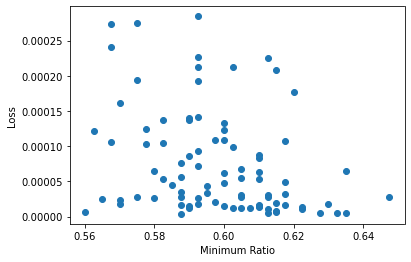

In [55]:
plt.xlabel("Minimum Ratio")
plt.ylabel("Loss")
plt.scatter(final_mi_array,final_loss_array)
plt.savefig("part2.3.png")